In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset

In [2]:
image_dir= Path('./Grape/')

filepaths = list(image_dir.glob(r'**/*.JPG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

# Use only healthy and black rot images
filepaths = [x for x, y in zip(filepaths, labels) if y in ['Grape___Black_rot', 'Grape___healthy']]
labels = [y for y in labels if y in ['Grape___Black_rot', 'Grape___healthy']]

In [3]:
# Create a DataFrame from filepaths and labels
filepaths = pd.DataFrame(filepaths, columns=['Filepath'])
labels = pd.DataFrame(labels, columns=['Label'])

# Concatenate the DataFrames
df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
df = df.sample(frac=1).reset_index(drop = True)

# Show the DataFrame
df.head()


,Filepath,Label
0,Grape\Grape___Black_rot\f5e5fde4-c121-40d8-b4a...,Grape___Black_rot
1,Grape\Grape___healthy\ef0cd637-5b34-489e-affc-...,Grape___healthy
2,Grape\Grape___Black_rot\8557739e-484e-42dc-871...,Grape___Black_rot
3,Grape\Grape___Black_rot\901e836a-591f-4b64-876...,Grape___Black_rot
4,Grape\Grape___Black_rot\308370b6-de46-4127-ad4...,Grape___Black_rot


In [4]:
# Show the number of images in each class
df['Label'].value_counts()

Grape___Black_rot    1180
Grape___healthy       423
Name: Label, dtype: int64

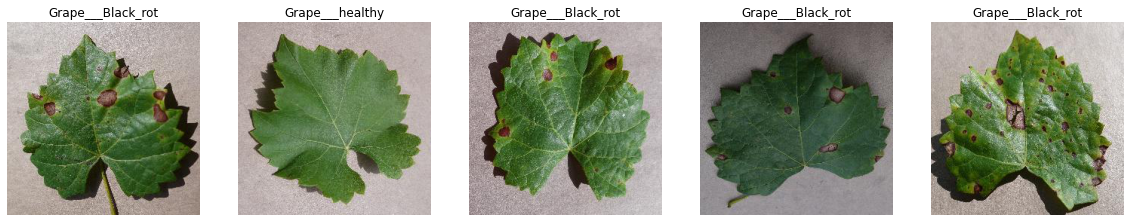

In [5]:
# Show first 5 images
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    image = plt.imread(df['Filepath'][i])
    ax[i].imshow(image)
    ax[i].set_title(df['Label'][i])
    ax[i].axis('off')
plt.show()


In [6]:
# Split the data into training and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
from custom_dataset import CustomDataset


# Define data transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create custom datasets for train and test data
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

## Model Architecture

In [8]:
import torch.nn as nn

class myCNN(nn.Module):
    # initialize the class and the parameters
    def __init__(self):
        super(myCNN, self).__init__()
        
        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3),
            nn.MaxPool2d(kernel_size=2))
        
        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.MaxPool2d(kernel_size=2))
        
        #Fully connected layer
        self.fc = nn.Linear(32*32*32, 2)
         
    # Feed forward the network
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out
model = myCNN()
print(model)

myCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=32768, out_features=2, bias=True)
)


In [9]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training and Validation

In [10]:
epochs = 5 # run more iterations
for epoch in range(epochs):
    running_loss = 0
    for images, classes in train_loader:
        # To device - to transfrom the image and classes to CPU|GPU
        images, classes = images.to(device), classes.to(device)
        
        # clears old gradients from the last step
        optimizer.zero_grad()
        
        # train the images
        outputs = model(images)
        
        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, classes)
        
        # compute the loss of every parameter
        loss.backward()
        
        # apply the optimizer and its parameters
        optimizer.step()
        
        #update the loss
        running_loss += loss.item()
        
    else:
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for images, classes in test_loader:          
                # Use GPU
                images, classes = images.to(device), classes.to(device)
                
                # validate the images
                outputs = model(images)
                
                # compute validation loss
                loss = criterion(outputs, classes)
                
                #update loss
                validation_loss += loss.item()
                
                # get the exponential of the outputs
                ps = torch.exp(outputs)
                
                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)
                
                # reshape the tensor
                equals = top_class == classes.view(*top_class.shape)
                
                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # change the mode to train for the next epochs
        model.train()
        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(test_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(test_loader)))

Epoch: 1/5..  Training Loss: 0.256..  Valid Loss: 0.261..  Valid Accuracy: 0.893
Epoch: 2/5..  Training Loss: 0.131..  Valid Loss: 0.138..  Valid Accuracy: 0.945
Epoch: 3/5..  Training Loss: 0.076..  Valid Loss: 0.123..  Valid Accuracy: 0.957
Epoch: 4/5..  Training Loss: 0.061..  Valid Loss: 0.097..  Valid Accuracy: 0.960
Epoch: 5/5..  Training Loss: 0.035..  Valid Loss: 0.088..  Valid Accuracy: 0.960


## Model prediction

In [11]:
# Plot the image
def imshow(image):
    fig, ax = plt.subplots()
    
    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image.transpose(0, 1, 2)
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    
    return ax

def process_image(image_path):
    
    test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])  
    
    im = Image.open(image_path)
    imshow(np.array(im))
    im = test_transform(im)
    return im

In [12]:
def predict(image, model):
    # we have to process the image as we did while training the others
    image = process_image(image)
    
    #returns a new tensor with a given dimension
    image_input = image.unsqueeze(0)
    
    # Convert the image to either gpu|cpu
    image_input.to(device)
    
    # Pass the image through the model
    outputs = model(image_input)
    ps = torch.exp(outputs)
    
    # return the top 5 most predicted classes
    top_p, top_cls = ps.topk(2, dim=1)
    # convert to numpy, then to list 
    top_cls = top_cls.detach().numpy().tolist()[0]
    
    idx_to_class = {
        0: 'Grape___healthy',
        1: 'Grape___Black_rot',
    }
    
    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    
    return top_p, top_cls

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_solution(image_path, ps, classes):
    plt.figure(figsize = (6,10))
    
    image = process_image(image_path)
    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2]);
    plt.show()

[10.436408042907715, 0.07915399223566055]
['Grape___Black_rot', 'Grape___healthy']


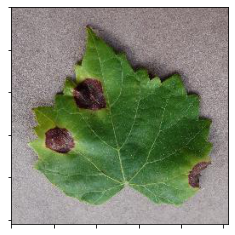

<Figure size 432x720 with 0 Axes>

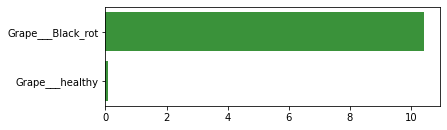

In [26]:
import random
# Select a random image from the test_df dataframe
image = random.choice(test_df['Filepath'].values)


#image = "./Grape/Grape___Black_rot/0d907173-6ef8-4fbd-b682-f0a7a5263de0___FAM_B.Rot 3298.JPG"
ps, classes = predict(image, model)
ps = ps.detach().numpy().tolist()[0]
print(ps)
print(classes)
plot_solution(image, ps, classes)